# Image Denoising using Convolutional Autoencoders

## 1) Import libraries

In [ ]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

## 2) Load MNIST dataset

* We'll use the MNIST hand-written digits dataset
* The input images are normalized to between 0 and 1
* We will use the original MNIST digits with shape (samples, 3, 28, 28)

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

11493376/11490434 [==============================] - 0s 0us/step


## 3) Add noise to the dataset

* We generate synthetic noisy digits by applying a gaussian noise matrix and clip the images between 0 and 1
* Plot some of the images from the dataset

In [ ]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

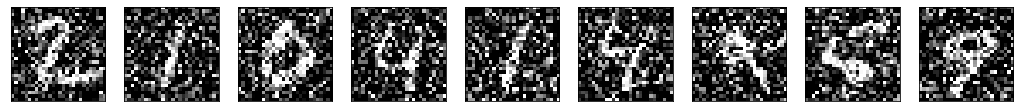

In [4]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 4) Define model architecture

The encoder will consist of a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist of a stack of Conv2D and UpSampling2D layers.

In [5]:
input_img = Input(shape=(28, 28, 1))  

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 32)        0     

## 5) Compile and Fit

In [6]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

early = EarlyStopping(monitor="val_loss", mode="min", patience=5)

history = autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[early])

Epoch 1/50
469/469 [==============================] - 6s 14ms/step - loss: 0.1611 - acc: 0.8076 - val_loss: 0.1152 - val_acc: 0.8090
Epoch 2/50
469/469 [==============================] - 6s 13ms/step - loss: 0.1117 - acc: 0.8114 - val_loss: 0.1071 - val_acc: 0.8111
Epoch 3/50
469/469 [==============================] - 6s 13ms/step - loss: 0.1062 - acc: 0.8122 - val_loss: 0.1033 - val_acc: 0.8114
Epoch 4/50
469/469 [==============================] - 6s 13ms/step - loss: 0.1033 - acc: 0.8126 - val_loss: 0.1017 - val_acc: 0.8115
Epoch 5/50
469/469 [==============================] - 6s 13ms/step - loss: 0.1017 - acc: 0.8128 - val_loss: 0.1003 - val_acc: 0.8122
Epoch 6/50
469/469 [==============================] - 6s 13ms/step - loss: 0.1005 - acc: 0.8130 - val_loss: 0.0993 - val_acc: 0.8118
Epoch 7/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0997 - acc: 0.8130 - val_loss: 0.0986 - val_acc: 0.8121
Epoch 8/50
469/469 [==============================] - 6s 13ms/step - 

## 6) Plot accuracy and loss curves

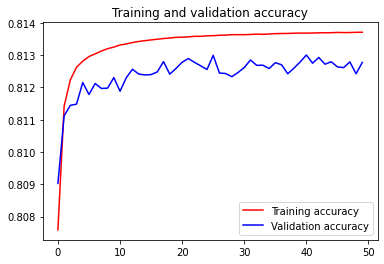

<Figure size 432x288 with 0 Axes>

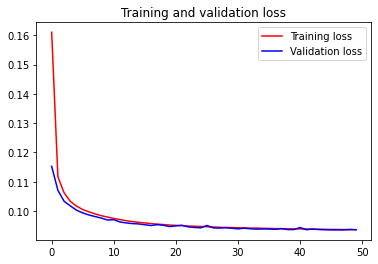

<Figure size 432x288 with 0 Axes>

In [7]:
def plot_history(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.figure()
  plt.show()
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend(loc=0)
  plt.figure()
  plt.show()

plot_history(history)

## 7) Predict on a sample image

In [ ]:
test_img = np.expand_dims(x_test_noisy[0].reshape(28, 28, 1), axis=0)
img_pred = autoencoder.predict(test_img) 

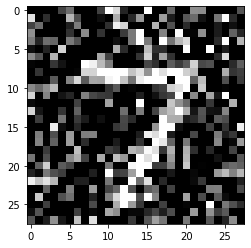

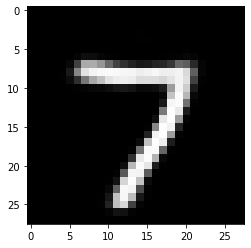

In [19]:
%matplotlib inline 

plt.imshow(np.squeeze(x_test_noisy[0].reshape(28, 28, 1)), interpolation='nearest')
plt.show()
plt.imshow(np.squeeze(img_pred), interpolation='nearest')
plt.show()